In [6]:
import dolfin as dolf
from math import pi
import numpy as np
from helmholtz_pkg.passive_flame import PassiveFlame
from helmholtz_pkg.flame_transfer_function import n_tau
from helmholtz_pkg.active_flame import ActiveFlame
from helmholtz_pkg.eigensolvers import fixed_point_iteration_pep
from helmholtz_pkg.eigenvectors import normalize_eigenvector

import params
import matplotlib.pyplot as plt

In [7]:
def mshr(el):

    mesh = dolf.UnitIntervalMesh(el)

    def l_boundary_func(x, on_boundary):
        x = x[0]
        return on_boundary and dolf.near(x, 0.)

    def r_boundary_func(x, on_boundary):
        x = x[0]
        return on_boundary and dolf.near(x, 1.)

    boundaries = dolf.MeshFunction('size_t', mesh, mesh.topology().dim() - 1)

    l_boundary = dolf.AutoSubDomain(l_boundary_func)
    r_boundary = dolf.AutoSubDomain(r_boundary_func)

    l_boundary.mark(boundaries, 1)
    r_boundary.mark(boundaries, 2)

    # ________________________________________________________________________________

    def fl_subdomain_func(x):
        x = x[0]
        x_f = params.x_f[0][0]
        a_f = params.a_f
        return x_f - a_f - dolf.DOLFIN_EPS <= x <= x_f + a_f + dolf.DOLFIN_EPS

    subdomains = dolf.MeshFunction('size_t', mesh, mesh.topology().dim())

    subdomains.set_all(1)

    fl_subdomain = dolf.AutoSubDomain(fl_subdomain_func)
    fl_subdomain.mark(subdomains, 0)
    
     
    
    return mesh, boundaries, subdomains



In [2]:
degree = 1

mesh, boundaries, subdomains = mshr(400)

boundary_conditions = {1: {'Robin': params.Y_in},  # inlet
                       2: {'Robin': params.Y_out}}  # outlet



NameError: name 'mshr' is not defined

In [ ]:
def calculate_volume_subdomain():
        V = FunctionSpace(mesh, 'CG', 3)
        u = dolf.interpolate(dolf.Expression('x[0]*x[0] + x[1]*x[1]+x[2]*x[2]'), V)
        
        dV = dolf.Measure('dx', subdomain_data = subdomains)
        print(dolf.assemble(u*dV(1)))

In [9]:
foo = PassiveFlame(mesh, boundaries, boundary_conditions,
                   c=params.c,
                   degree=degree)
foo.assemble_A()
foo.assemble_B()
foo.assemble_C()

ftf = n_tau(params.n, params.tau)

D = ActiveFlame(mesh, subdomains,
                params.x_f, params.x_r, params.rho_in, 1., 1., ftf,
                degree=degree)
# D.matrix.getValues(range(400),range(400))
# 

iter =  1,  omega = +3.42658955  +0.01448821j,  |domega| = 1.28e-02
iter =  2,  omega = +3.42440924  +0.00224480j,  |domega| = 1.24e-02
iter =  3,  omega = +3.42440954  +0.00224595j,  |domega| = 1.19e-06
iter =  4,  omega = +3.42440954  +0.00224595j,  |domega| = 5.62e-11


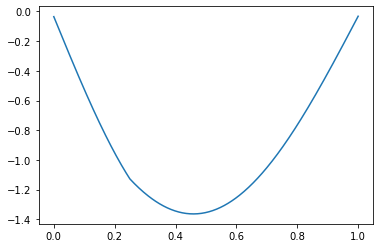

In [10]:
D.assemble_submatrices()

E = fixed_point_iteration_pep(foo, D, pi, nev=2, i=0)

omega, p = normalize_eigenvector(mesh, E, i=0, degree=degree)

p_r, p_i = p.split(True)
dolf.plot(p_r)

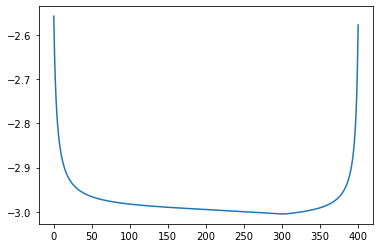

In [11]:
vector = p_r.vector()[:]+1j*p_i.vector()[:]
plt.plot(np.angle(vector))

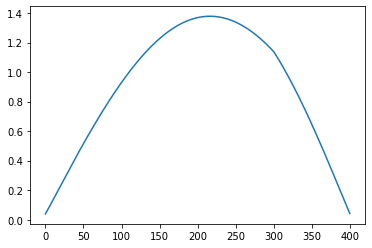

In [12]:
plt.plot(np.abs(vector))

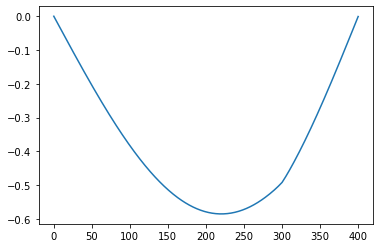

In [13]:
vector*=np.exp(-1j*np.angle(vector)[0])
plt.plot(vector.imag)

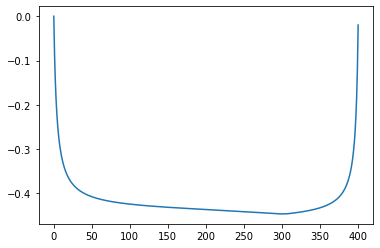

In [14]:
plt.plot(np.angle(vector))

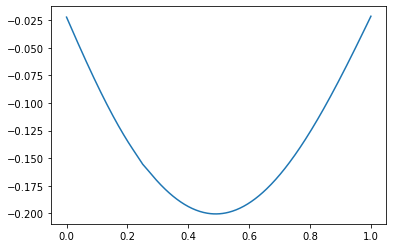

In [15]:
dolf.plot(p_i)